<a href="https://colab.research.google.com/github/marinaD10/PRA3024/blob/main/Challenge2_assignment2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

/usr/local/lib/python3.10/dist-packages/pycbc/types/array.py:36: UserWarning: Wswiglal-redir-stdio:

SWIGLAL standard output/error redirection is enabled in IPython.
This may lead to performance penalties. To disable locally, use:

with lal.no_swig_redirect_standard_output_error():
    ...

To disable globally, use:

lal.swig_redirect_standard_output_error(True)

Note however that this will likely lead to error messages from
LAL functions being either misdirected or lost when called from
Jupyter notebooks.

To suppress this warning, use:

import warnings
warnings.filterwarnings("ignore", "Wswiglal-redir-stdio")
import lal

  import lal as _lal


Text(0, 0.5, 'strain')

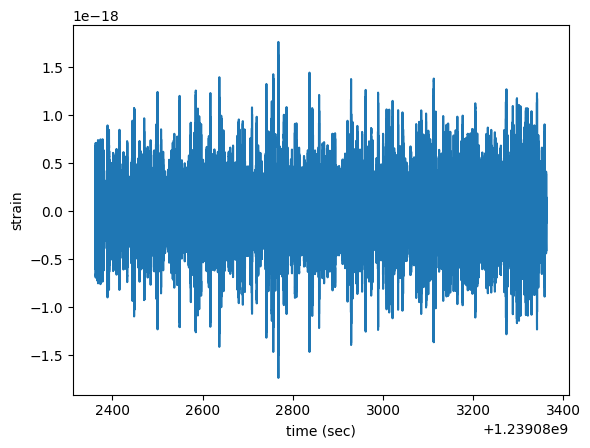

In [1]:
# Loading the data
! pip install -q lalsuite
! pip install -q gwpy
! pip install -q pycbc
import numpy as np
import pycbc
from pycbc.types import FrequencySeries, TimeSeries
import matplotlib.pyplot as plt
d = np.load('noise_ts_4096Hz.npy')
time = d[:, 0]
d = pycbc.types.TimeSeries(d[:, 1], delta_t = time[1]-
time[0])
data = d
plt.plot(time, data)
plt.xlabel('time (sec)')
plt.ylabel('strain')

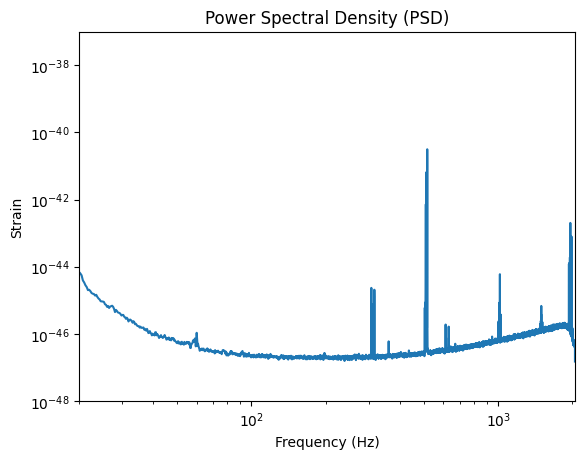

In [2]:
# Finding and plotting the power spectral density (PSD)
psd = data.psd(4)
plot=plt.loglog(psd.sample_frequencies, psd)
plt.xlim(xmin=20, xmax=psd.sample_rate/2)
plt.ylim(ymin=1e-48,ymax=1e-37)
plt.title('Power Spectral Density (PSD)')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Strain')
plt.show()

0.25


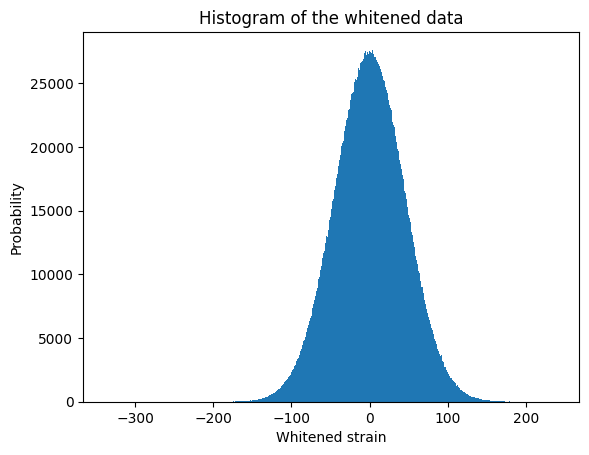

In [3]:
# Whitening the data and plotting a histogram of it
from pycbc.psd import interpolate
print(psd.delta_f)
psd = interpolate(psd, data.delta_f)
psd[0] = psd[1]
psd[len(psd) - 1] = psd[len(psd) - 2]
data_whitened = (data.to_frequencyseries() / psd**0.5).to_timeseries()
data_whitened= data_whitened.crop(4,4)
plt.title('Histogram of the whitened data')
plt.xlabel('Whitened strain')
plt.ylabel('Probability')
hist=plt.hist(data_whitened,bins='auto')

In [4]:
from pycbc.waveform import get_fd_waveform
hp, hc = get_fd_waveform(approximant="TaylorF2",
mass1=3,
mass2=3,
delta_f=1.0/(200.0) ,
distance = 500,
f_lower=20.0, f_final = 2048.0) #Luminosity distance = 500 Mpc


In [5]:
from pycbc.psd import interpolate
from pycbc.filter import sigmasq
print(psd.delta_f)
psd = interpolate(psd, data.delta_f)
psd[0] = psd[1]
psd[len(psd) - 1] = psd[len(psd) - 2]

print(hp.delta_f)
hp = interpolate(hp, data.delta_f)
hp[0] = hp[1]
hp[len(hp) - 1] = hp[len(hp) - 2]

SNR = (pycbc.filter.sigmasq(hp, psd))**0.5
print(SNR)

0.001
0.005
9.307949281681198


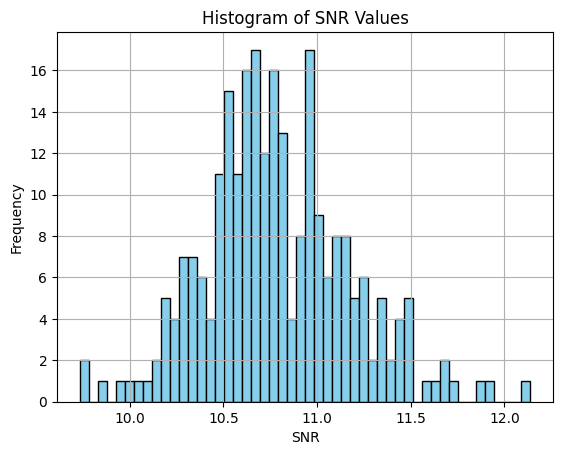

In [17]:
# Developing a test to show that the stationarity does not hold by calculating
# and proving that there is different SNR values for the separate chunks of data
import numpy as np
import pycbc
from pycbc.types import TimeSeries
from pycbc.psd import welch
from pycbc.filter import sigmasq

total_duration = len(data) * data.delta_t # The total duration
chunk_duration = 4
total_chunks = int(total_duration / chunk_duration)
chunk_length = int(chunk_duration / data.delta_t)
snr_values = []
# A for loop for each chunk of data
for i in range(total_chunks):
    start_index = i * chunk_length
    end_index = min((i + 1) * chunk_length, len(data))

    chunk_data = data[start_index:end_index]

    # Estimating the power spectral density (PSD) using Welch's method
    psd = welch(chunk_data)

    # Calculating the SNR
    hp, hc = pycbc.waveform.get_fd_waveform(approximant="TaylorF2", mass1=3, mass2=3, delta_f=psd.delta_f, distance=500, f_lower=20.0, f_final=2048.0)
    SNR = (sigmasq(hp, psd))**0.5
    snr_values.append(SNR)


# Plotting a histogram of the SNR values
plt.hist(snr_values, bins=50, color='skyblue', edgecolor='black')
plt.xlabel('SNR')
plt.ylabel('Frequency')
plt.title('Histogram of SNR Values')
plt.grid(True)
plt.show()

# This was done with the help of ChatGPT
# Reference: OpenAI. (2024). ChatGPT (3.5) [Large language model]. https://chat.openai.com/chat